In [2]:

import sys
import os
current_dir = os.path.dirname(os.path.abspath('./'))
if not current_dir in sys.path:
    sys.path.append(current_dir)
    
from utils.structures import Pipeline, Deploy
from utils.data_management import dict2str
from typing import *
import tensorflow as tf
from sklearn.datasets import make_classification
import mne
from combiners import EpochsCombiner
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from matplotlib.pyplot import figure
from utils.machine_learning.designer import ModelDesign, ParallelDesign, LayerDesign
from utils.machine_learning.analyzer import ModelAnalyzer, LFCNNAnalyzer


2022-01-29 22:53:43.028975: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-29 22:53:43.029018: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
# Prepare data

content_root = '../'
subjects_folder_path = os.path.join(content_root, 'Source/Subjects')
subject_path = os.path.join(subjects_folder_path, 'Az_Mar_05')
info_path = os.path.join(subject_path, 'Info',
                        'ML_Subject05_P1_tsss_mc_trans_info.pkl')

resp_lock_lm_B1_epochs_path = os.path.join(
    subject_path, 'Epochs', 'RespCor_LM_B1_epochs.fif')
resp_lock_rm_B1_epochs_path = os.path.join(
    subject_path, 'Epochs', 'RespCor_RM_B1_epochs.fif')
resp_lock_li_B1_epochs_path = os.path.join(
    subject_path, 'Epochs', 'RespCor_LI_B1_epochs.fif')
resp_lock_ri_B1_epochs_path = os.path.join(
    subject_path, 'Epochs', 'RespCor_RI_B1_epochs.fif')

resp_lock_lm_B1_epochs = mne.read_epochs(resp_lock_lm_B1_epochs_path)
resp_lock_li_B1_epochs = mne.read_epochs(resp_lock_li_B1_epochs_path)
resp_lock_rm_B1_epochs = mne.read_epochs(resp_lock_rm_B1_epochs_path)
resp_lock_ri_B1_epochs = mne.read_epochs(resp_lock_ri_B1_epochs_path)

resp_lock_li_B1_epochs.resample(200)
resp_lock_lm_B1_epochs.resample(200)
resp_lock_ri_B1_epochs.resample(200)
resp_lock_rm_B1_epochs.resample(200)

combiner = EpochsCombiner(
    resp_lock_lm_B1_epochs.copy(),
    resp_lock_li_B1_epochs.copy(),
    resp_lock_rm_B1_epochs.copy(),
    resp_lock_ri_B1_epochs.copy()
)
first_class_indices = (0, 1)
second_class_indices = (2, 3)
combiner.combine(first_class_indices, second_class_indices, shuffle=True)

Reading /home/user/Projects/FingerMovementDecoder/dirty_field/../Source/Subjects/Az_Mar_05/Epochs/RespCor_LM_B1_epochs.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Reading /home/user/Projects/FingerMovementDecoder/dirty_field/../Source/Subjects/Az_Mar_05/Epochs/RespCor_LI_B1_epochs.fif ...


/tmp/ipykernel_2730272/1891160227.py:18: RuntimeWarning: This filename (../Source/Subjects/Az_Mar_05/Epochs/RespCor_LM_B1_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  resp_lock_lm_B1_epochs = mne.read_epochs(resp_lock_lm_B1_epochs_path)
/tmp/ipykernel_2730272/1891160227.py:19: RuntimeWarning: This filename (../Source/Subjects/Az_Mar_05/Epochs/RespCor_LI_B1_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  resp_lock_li_B1_epochs = mne.read_epochs(resp_lock_li_B1_epochs_path)


    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
27 matching events found
No baseline correction applied
0 projection items activated
Reading /home/user/Projects/FingerMovementDecoder/dirty_field/../Source/Subjects/Az_Mar_05/Epochs/RespCor_RM_B1_epochs.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Reading /home/user/Projects/FingerMovementDecoder/dirty_field/../Source/Subjects/Az_Mar_05/Epochs/RespCor_RI_B1_epochs.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available


/tmp/ipykernel_2730272/1891160227.py:20: RuntimeWarning: This filename (../Source/Subjects/Az_Mar_05/Epochs/RespCor_RM_B1_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  resp_lock_rm_B1_epochs = mne.read_epochs(resp_lock_rm_B1_epochs_path)
/tmp/ipykernel_2730272/1891160227.py:21: RuntimeWarning: This filename (../Source/Subjects/Az_Mar_05/Epochs/RespCor_RI_B1_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  resp_lock_ri_B1_epochs = mne.read_epochs(resp_lock_ri_B1_epochs_path)


Not setting metadata
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated


[<EpochsFIF |  30 events (all good), -0.5 - 0.495 sec, baseline off, ~14.5 MB, data loaded,
 '0': 30>, <EpochsFIF |  27 events (all good), -0.5 - 0.495 sec, baseline off, ~13.5 MB, data loaded,
 '0': 27>, <EpochsFIF |  30 events (all good), -0.5 - 0.495 sec, baseline off, ~14.5 MB, data loaded,
 '0': 30>, <EpochsFIF |  30 events (all good), -0.5 - 0.495 sec, baseline off, ~14.5 MB, data loaded,
 '0': 30>]

In [3]:
n_epochs, n_channels, n_times = combiner.X.shape

inputs = tf.keras.Input(shape=(n_channels, n_times, 1), name='input_layer')
X = tf.keras.layers.Conv2D(32, (n_channels, 1), activation=tf.nn.relu, name='spatial_filters_layer')(inputs)
X = tf.keras.layers.DepthwiseConv2D((1, 15), padding='same', activation=tf.nn.relu, name='temporal_filters_layer')(X)
X = tf.transpose(X, perm=(0, 3, 2, 1))
X = tf.keras.layers.MaxPool2D(pool_size=(1, 2))(X)
X = tf.keras.layers.Flatten()(X)
X = tf.keras.layers.Dense(400, activation=tf.nn.relu)(X)
X = tf.keras.layers.Dense(200, activation=tf.nn.relu)(X)
X = tf.keras.layers.Dense(100, activation=tf.nn.relu)(X)
X = tf.keras.layers.Dense(50, activation=tf.nn.relu)(X)
outputs = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)(X)
print(X.shape)


(None, 1, 200, 32)


2022-01-20 14:17:24.507486: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-20 14:17:24.507515: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-20 14:17:24.507530: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (arcolinux-machine): /proc/driver/nvidia/version does not exist
2022-01-20 14:17:24.507713: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


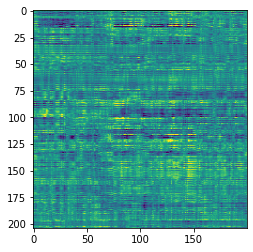

In [7]:
# print(combiner.X)
plt.imshow(combiner.X[0], vmin=-1e-11, vmax=1e-11)

In [3]:
X = combiner.X.copy()
Y = combiner.Y.copy()
X = np.reshape(X, (*X.shape, 1))

X_train, X_test, y_train, y_test = train_test_split(X, Y)

In [21]:
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.MeanSquaredLogarithmicError(),
    metrics=['acc'],
)




model.fit(
    X_train,
    y_train,
    epochs=25,
    validation_split=0.2,
    shuffle=True,
    # batch_size=50,
    # callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),]
)

Epoch 1/25
3/3 [==============================] - 1s 122ms/step - loss: 0.1253 - acc: 0.5217 - val_loss: 0.1189 - val_acc: 0.4444
Epoch 2/25
3/3 [==============================] - 0s 35ms/step - loss: 0.1245 - acc: 0.5217 - val_loss: 0.1187 - val_acc: 0.4444
Epoch 3/25
3/3 [==============================] - 0s 35ms/step - loss: 0.1235 - acc: 0.5217 - val_loss: 0.1187 - val_acc: 0.4444
Epoch 4/25
3/3 [==============================] - 0s 38ms/step - loss: 0.1217 - acc: 0.5217 - val_loss: 0.1193 - val_acc: 0.4444
Epoch 5/25
3/3 [==============================] - 0s 36ms/step - loss: 0.1193 - acc: 0.5217 - val_loss: 0.1241 - val_acc: 0.4444
Epoch 6/25
3/3 [==============================] - 0s 36ms/step - loss: 0.1204 - acc: 0.5217 - val_loss: 0.1369 - val_acc: 0.4444
Epoch 7/25
3/3 [==============================] - 0s 35ms/step - loss: 0.1267 - acc: 0.5217 - val_loss: 0.1344 - val_acc: 0.4444
Epoch 8/25
3/3 [==============================] - 0s 37ms/step - loss: 0.1237 - acc: 0.5217 - va

In [22]:
print(
    model(X_test).numpy()
)

[[0.42091185]
 [0.42091185]
 [0.42091185]
 [0.42091185]
 [0.42091185]
 [0.42091185]
 [0.42091185]
 [0.42091185]
 [0.42091185]
 [0.42091185]
 [0.42091185]
 [0.42091185]
 [0.42091185]
 [0.42091185]
 [0.42091185]
 [0.42091185]
 [0.42091185]
 [0.42091185]
 [0.42091185]
 [0.42091185]
 [0.42091185]
 [0.42091185]
 [0.42091185]
 [0.42091185]
 [0.42091185]
 [0.42091185]
 [0.42091185]
 [0.42091185]
 [0.42091185]
 [0.42091185]]


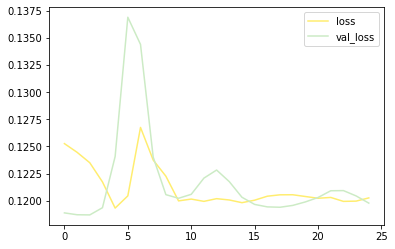

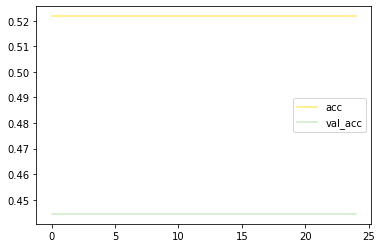

<Figure size 432x288 with 0 Axes>

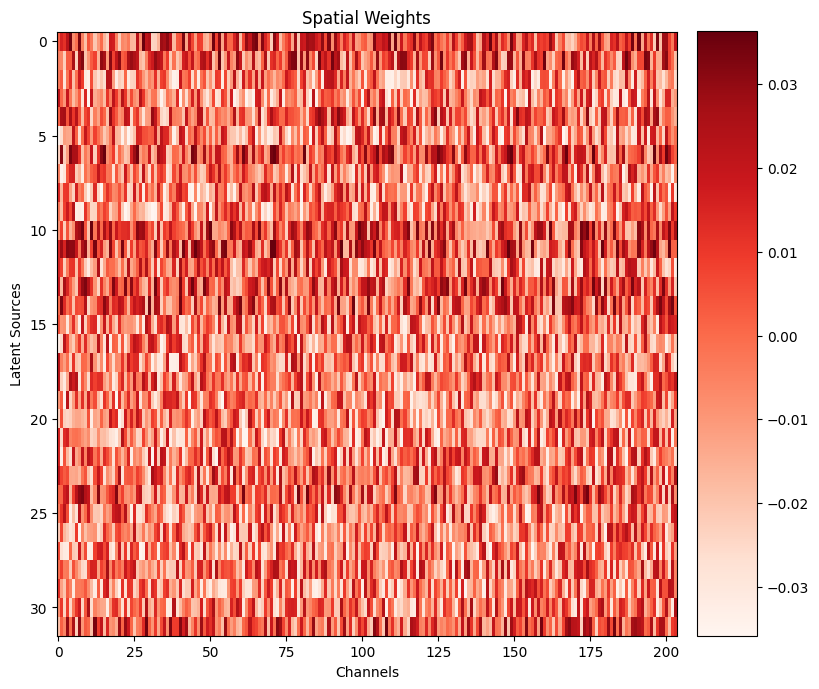

<Figure size 432x288 with 0 Axes>

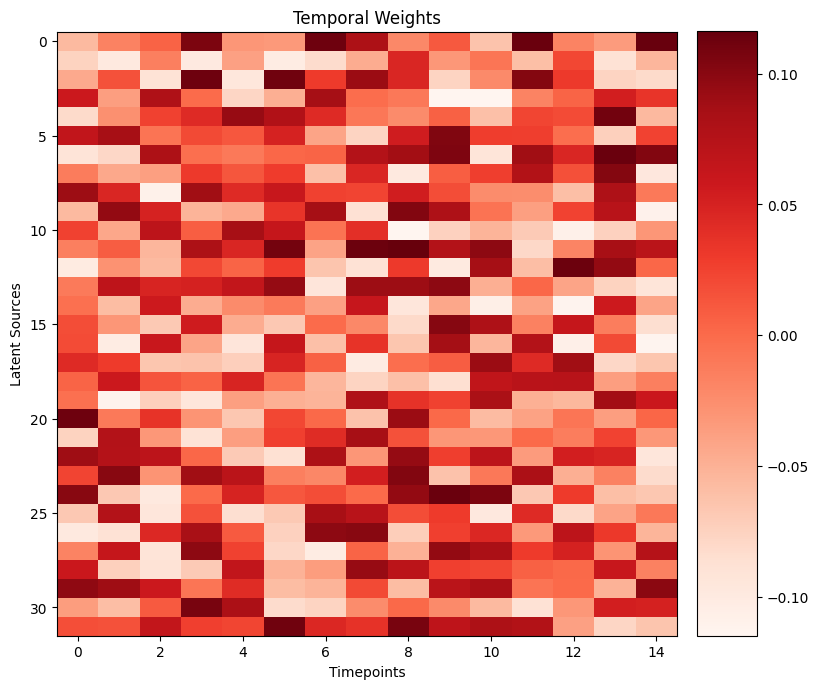

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [23]:
analyzer = LFCNNAnalyzer(model)

analyzer.plot_metrics(['loss', 'val_loss'])
analyzer.plot_metrics(['acc', 'val_acc'])
analyzer.plot_spatial_weights()
analyzer.plot_temporal_weights(transpose=True)

In [22]:
X = combiner.X.copy()
Y = combiner.Y.copy()
X = np.reshape(X, (*X.shape, 1))


def one_hot_encoding(Y: np.ndarray) -> np.ndarray:
    y = list()
    n_classes = len(np.unique(Y))

    for val in Y:
        new_y_value = np.zeros(n_classes)
        new_y_value[val] = 1
        y.append(new_y_value)

    return np.array(y)

def one_hot_decoder(y: np.array) -> np.array:
    y_decoded = list()
    for val in y:
        y_decoded.append(np.where(val == val.max())[0][0])
    
    return np.array(y_decoded)

Y = one_hot_encoding(Y)

X_train, X_test, y_train, y_test = train_test_split(X, Y)


In [31]:
n_samples, n_channels, n_times, n_1 = X.shape
n_classes = len(np.unique(Y))

lfcnn_design = ModelDesign(
    tf.keras.Input(shape=(n_channels, n_times, 1), name='input_layer'),
    tf.keras.layers.Conv2D(32, (n_channels, 1), activation=tf.nn.relu, name='spatial_filters_layer', kernel_regularizer='l2'),
    tf.keras.layers.DepthwiseConv2D((1, 15), padding='same', activation=tf.nn.relu, name='temporal_filters_layer', kernel_regularizer='l2'),
    LayerDesign(tf.transpose, perm=(0, 3, 2, 1)),
    tf.keras.layers.MaxPool2D(pool_size=(1, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(400, activation=tf.nn.relu),
    tf.keras.layers.Dense(200, activation=tf.nn.relu),
    tf.keras.layers.Dense(100, activation=tf.nn.relu),
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    tf.keras.layers.Dense(n_classes, activation=tf.nn.softmax)
)

Epoch 1/50
2/2 [==============================] - 1s 287ms/step - loss: 0.7120 - acc: 0.4808 - val_loss: 0.7089 - val_acc: 0.5429
Epoch 2/50
2/2 [==============================] - 0s 65ms/step - loss: 0.7083 - acc: 0.5192 - val_loss: 0.7053 - val_acc: 0.5429
Epoch 3/50
2/2 [==============================] - 0s 65ms/step - loss: 0.7053 - acc: 0.5192 - val_loss: 0.7025 - val_acc: 0.5429
Epoch 4/50
2/2 [==============================] - 0s 67ms/step - loss: 0.7025 - acc: 0.5192 - val_loss: 0.7004 - val_acc: 0.5429
Epoch 5/50
2/2 [==============================] - 0s 65ms/step - loss: 0.7003 - acc: 0.5192 - val_loss: 0.6985 - val_acc: 0.5429
Epoch 6/50
2/2 [==============================] - 0s 69ms/step - loss: 0.6985 - acc: 0.5192 - val_loss: 0.6968 - val_acc: 0.5429
Epoch 7/50
2/2 [==============================] - 0s 80ms/step - loss: 0.6970 - acc: 0.5192 - val_loss: 0.6954 - val_acc: 0.5429
Epoch 8/50
2/2 [==============================] - 0s 85ms/step - loss: 0.6958 - acc: 0.5192 - va

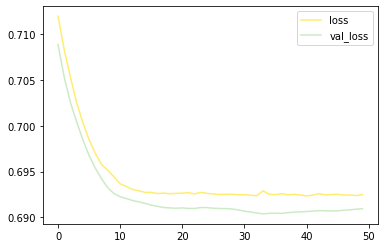

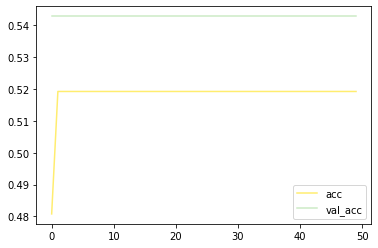

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [32]:
from utils.machine_learning.analyzer import LFCNNAnalyzer

model = lfcnn_design.build()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['acc']
)

model.fit(
    X_train,
    y_train,
    epochs=50,
    validation_split=0.4,
    shuffle=True,
)

model_analyzer = LFCNNAnalyzer(model)

model_analyzer.plot_metrics(['loss', 'val_loss'])
model_analyzer.plot_metrics(['acc', 'val_acc'])

In [44]:
y_pred = model(X_test).numpy()
y_pred_int = np.round(y_pred, 1)

    

# for y_p, y in zip(y_pred_decoded, y_test_decoded):
#     print(y_p, y)

def one_hot_decoder(y: np.array) -> np.array:
    y_decoded = list()
    for val in y:
        y_decoded.append(np.where(val == val.max())[0][0])
    
    return np.array(y_decoded)
    
y_pred_decoded = one_hot_decoder(y_pred_int)
y_test_decoded = one_hot_decoder(y_test)
print('Actual prediction | Rounded prediction | Decoded | Actual')
for ap, rp, p, a in zip(y_pred, y_pred_int, y_pred_decoded, y_test_decoded):
    print(' ', np.round(ap, 3), '        ', rp, '        ', p, '      ', a)

Actual prediction | Rounded prediction | Decoded | Actual
  [0.484 0.516]          [0.5 0.5]          0        0
  [0.484 0.516]          [0.5 0.5]          0        1
  [0.484 0.516]          [0.5 0.5]          0        0
  [0.484 0.516]          [0.5 0.5]          0        0
  [0.484 0.516]          [0.5 0.5]          0        0
  [0.484 0.516]          [0.5 0.5]          0        0
  [0.484 0.516]          [0.5 0.5]          0        0
  [0.484 0.516]          [0.5 0.5]          0        1
  [0.484 0.516]          [0.5 0.5]          0        0
  [0.484 0.516]          [0.5 0.5]          0        1
  [0.484 0.516]          [0.5 0.5]          0        1
  [0.484 0.516]          [0.5 0.5]          0        1
  [0.484 0.516]          [0.5 0.5]          0        0
  [0.484 0.516]          [0.5 0.5]          0        0
  [0.484 0.516]          [0.5 0.5]          0        1
  [0.484 0.516]          [0.5 0.5]          0        1
  [0.484 0.516]          [0.5 0.5]          0        0
  [0.48